# Running Dask on AzureML

This notebook shows how to run a Dask cluster on an AzureML Compute cluster. 
For setup instructions of you python environment, please see the [Readme](../README.md)

In [1]:
import time

from azureml.core import Workspace, Experiment
from azureml.core.runconfig import RunConfiguration, MpiConfiguration
from azureml.train.estimator import Estimator


## Starting the cluster

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='SCUS-AzureML', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersRG')

In [3]:
# D12 v2	4	28 GiB	200 GiB	$0.379/hour
ct = ws.compute_targets['ds12v2-cluster']
ct

AmlCompute(workspace=Workspace.create(name='SCUS-AzureML', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersRG'), name=ds12v2-cluster, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersRG/providers/Microsoft.MachineLearningServices/workspaces/SCUS-AzureML/computes/ds12v2-cluster, type=AmlCompute, provisioning_state=Succeeded, location=southcentralus, tags=None)

Starting the Dask cluster using an Estimator with MpiConfiguration. Make sure the cluster is able to scale up to 10 nodes or change the `node_count` below. 

In [6]:
est = Estimator('dask', 
                compute_target=ct, 
                entry_script='startDask.py', 
                conda_dependencies_file='environment.yml', 
                script_params={'--datastore': ws.get_default_datastore()},
                node_count=50,
                distributed_training=MpiConfiguration())

run = Experiment(ws, 'dask').submit(est)

In [5]:
from IPython.display import clear_output

print("waiting for scheduler node's ip")
while not 'headnode' in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

clear_output()
headnode_private_ip = run.get_metrics()['headnode']
print('Headnode has IP:', headnode_private_ip)

waiting for scheduler node's ip
..........................................................................................................................................

KeyboardInterrupt: 

In [ ]:
# let's find the public IP and ssh port of the head node

headnode_public_ip = None
headnode_ssh_port = None
for node in ct.list_nodes():
    if node['privateIpAddress'] == headnode_private_ip:
        headnode_public_ip = node['publicIpAddress']
        headnode_ssh_port = node['port']
        break
        
if headnode_public_ip == None:
    print('Headnode not found in cluster')
else:
    print(f'Headnode is at {headnode_public_ip}:{headnode_ssh_port}')

## Establish the port-forwarding from Notebook VM to Dask Scheduler
Since Notebook VM does not yet support VNets, you need to build an SSH port forwarder through SSH login.

In the prior cell we looked up the public IP and port of the headnode of the cluster 

Now, open the terminal on the Notebook VM and type what the following cell outputs  


In [13]:
print(f'ssh daskuser@{headnode_public_ip} -p {headnode_ssh_port} -L 8786:localhost:8786 -L 8788:{headnode_private_ip}:8787 -L 9999:localhost:8888')

ssh daskuser@52.248.98.93 -p 50000 -L 8786:localhost:8786 -L 8788:10.0.0.4:8787 -L 9999:localhost:8888


Make sure to leave the terminal tab open to keep the port-forward running

As you see, you are forwarding 3 ports 

1. 8786 is for the scheduler and will be used to connect the client to the cluster
2. 8788 is for the Bokeh app that shows the activity on the cluster (we are mapping to the local port 8788 to avoid a conflict with the RStudio Server running on the Notebook VM)
3. 9999 is for a jupyter instance running on the head node. You can connect to the scheduler from the jupyter running on your Notebook VM or from this jupyter instance on the head node.   

To access the Bokeh app, change the URL to your notebook VM by adding `-8788` right after the machine name. If you are running this notebook on a Notebook VM, then you can create the URLs by excuting the next cell:

In [ ]:
print("waiting for jupyter token")
while not 'jupyter-token' in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

# this will only work when running on a Notebook VM
DaskURLs('8788', '9999', run.get_metrics()['jupyter-token'])

Hopefully, you are seeing this after you clicked on the Bokeh link and then select 'Status':

![Bokeh](../img/bokeh.png)

If you are wondering what all this port business in accomplishing, please see the graph below that tries to illustrate who talks to whom and how.

![Network](../img/network.png)

## Run some jobs on the cluster
If you are able to see the Bokeh app, it is time to use the cluster. Thanks to the port forward, the scheduler appears to the notebook VM at `tcp://localhost:8786`. You should see 10 workers.

In [14]:
exp = Experiment(ws, 'dask')
exp

Name,Workspace,Report Page,Docs Page
dask,SCUS-AzureML,Link to Azure Machine Learning studio,Link to Documentation


In [15]:
runs = exp.get_runs()
run = next(runs)
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask,dask_1576202839_c1820fde,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


In [16]:
import dask
import dask.dataframe as dd

In [17]:
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline

In [62]:
from dask.distributed import Client

c = Client('tcp://localhost:8786')
c.restart()
c

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 40 Cores: 800 Memory: 5.91 TB


In [63]:
ds = run.get_metrics()['datastore']
ds

'/mnt/batch/tasks/shared/LS_root/jobs/scus-azureml/azureml/dask_1576202839_c1820fde/mounts/workspaceblobstore'

In [64]:
path = ds + ''
path

'/mnt/batch/tasks/shared/LS_root/jobs/scus-azureml/azureml/dask_1576202839_c1820fde/mounts/workspaceblobstore'

In [65]:
def load_data(path):
    df = dd.read_csv(path+'/datasets/isd/*data.csv', dtype={'usaf': 'object'})
    return df

In [ ]:
NoaaIsd().to_dask_dataframe()

In [66]:
df = dask.delayed(load_data)(path).compute()

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


In [68]:
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,63858,2010-01-01 00:00:00,32.457,-87.242,59.0,0.0,0.0,6.2,NaN,...,NaN,1.0,0.0,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
1,999999,63858,2010-01-01 00:05:00,32.457,-87.242,59.0,NaN,NaN,6.3,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
2,999999,63858,2010-01-01 00:10:00,32.457,-87.242,59.0,NaN,NaN,6.3,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
3,999999,63858,2010-01-01 00:15:00,32.457,-87.242,59.0,NaN,NaN,6.4,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
4,999999,63858,2010-01-01 00:20:00,32.457,-87.242,59.0,NaN,NaN,5.6,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0


In [69]:
df.npartitions

3652

In [71]:
%time len(df)

CPU times: user 8.22 s, sys: 641 ms, total: 8.86 s
Wall time: 2min 19s


1226495195

In [72]:
df.datetime = dd.to_datetime(df.datetime).dt.floor('d')

In [73]:
df = df.repartition(npartitions=150)

In [74]:
df = df.set_index(df.datetime, sorted=True).persist()

/home/cody/miniconda3/envs/dasky/lib/python3.6/site-packages/dask/dataframe/shuffle.py:683: UserWarning: Partition indices have overlap.
  warnings.warn("Partition indices have overlap.")


In [75]:
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01,999999,63858,2010-01-01,32.457,-87.242,59.0,0.0,0.0,6.2,NaN,...,NaN,1.0,0.0,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
2010-01-01,999999,63858,2010-01-01,32.457,-87.242,59.0,NaN,NaN,6.3,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
2010-01-01,999999,63858,2010-01-01,32.457,-87.242,59.0,NaN,NaN,6.3,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
2010-01-01,999999,63858,2010-01-01,32.457,-87.242,59.0,NaN,NaN,6.4,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0
2010-01-01,999999,63858,2010-01-01,32.457,-87.242,59.0,NaN,NaN,5.6,NaN,...,NaN,NaN,NaN,NaN,SELMA 13 WNW,US,999999-63858,2010,1,1.0


In [85]:
%time len(df)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 308 ms


1226495195

In [86]:
df.npartitions

150

In [87]:
df2 = df.persist()

In [88]:
df.describe().compute()

,wban,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.226495e+09,1.226495e+09,1.226495e+09,1.226495e+09,9.860729e+08,1.024169e+09,1.204908e+09,4.439680e+08,1.126083e+08,4.811327e+07,2.677125e+08,2.677125e+08,8.030425e+06,1.226495e+09,1.226495e+09,1.226495e+09
mean,7.045103e+04,3.727649e+01,-3.788130e+01,4.023863e+02,1.653440e+02,3.420428e+00,1.211205e+01,1.014682e+03,2.962371e+01,4.313248e+00,1.021693e+01,1.222342e+03,1.825298e+01,2.014615e+03,1.568794e+01,1.000000e+00
std,3.920567e+04,2.185938e+01,7.903229e+01,6.210085e+02,1.143895e+02,2.856515e+00,1.248980e+01,9.337869e+00,2.939881e+01,2.997728e+00,2.120188e+01,3.260760e+03,3.120283e+01,2.854621e+00,8.819862e+00,0.000000e+00
min,1.000000e+02,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.010000e+03,1.000000e+00,1.000000e+00
25%,5.490100e+04,3.392900e+01,-9.117600e+01,5.900000e+01,8.000000e+01,2.000000e+00,8.900000e+00,1.011800e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03,1.200000e+01,1.000000e+00
50%,9.999900e+04,4.169100e+01,-4.743400e+01,2.240000e+02,2.000000e+02,3.100000e+00,1.650000e+01,1.017200e+03,4.700000e+01,6.000000e+00,3.000000e+00,0.000000e+00,1.600000e+01,2.016000e+03,1.900000e+01,1.000000e+00
75%,9.999900e+04,4.930800e+01,2.185400e+01,5.450000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.028000e+03,7.100000e+01,8.000000e+00,2.400000e+01,9.999000e+03,6.100000e+01,2.019000e+03,2.600000e+01,1.000000e+00
max,9.999900e+04,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.019000e+03,3.100000e+01,1.000000e+00


In [89]:
means = df.groupby(df.index).mean().compute()
means.head()

,wban,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,,
2010-01-01,70525.343200,37.776330,-44.789609,367.457485,177.238952,3.535235,0.506604,1014.939217,33.677905,4.477928,5.223530,119.163527,18.598648,2010.0,1.0,1.0
2010-01-02,72058.078286,37.738066,-42.264066,370.833385,182.044743,3.763542,-1.225774,1017.668228,35.451896,4.563842,5.760318,101.550949,19.187241,2010.0,2.0,1.0
2010-01-03,72028.429808,37.810610,-42.360270,371.423608,169.487012,3.569742,-1.677575,1018.604089,36.280457,4.697030,5.741719,95.992435,18.889673,2010.0,3.0,1.0
2010-01-04,72409.853682,37.758072,-41.512760,372.120695,182.084952,3.442236,-1.313476,1017.617982,34.397468,4.399583,5.774428,114.722618,18.758991,2010.0,4.0,1.0
2010-01-05,72461.408967,37.837368,-42.038015,370.962488,175.586019,3.331567,-1.278644,1016.278692,33.552544,4.371871,5.672136,108.018338,17.794466,2010.0,5.0,1.0


In [90]:
df = df.drop(['datetime'], axis=1)

In [91]:
df.index

Dask Index Structure:
npartitions=150
2010-01-01    datetime64[ns]
2010-01-25               ...
                   ...      
NaT                      ...
NaT                      ...
Name: datetime, dtype: datetime64[ns]
Dask Name: drop, 450 tasks

In [92]:
def write_data(path):
    df.to_parquet(path)

In [93]:
a = dask.delayed(write_data)(ds+'/dask/outputs/isd').compute()

OSError: Timed out trying to connect to 'tcp://127.0.0.1:8786' after 3 s: in <distributed.comm.tcp.TCPConnector object at 0x7fb708a2ff98>: ConnectionRefusedError: [Errno 111] Connection refused

In [124]:
counts = df.groupby([df.index.month, df.index.year]).day.count().compute()

In [136]:
cs = [counts[month][2015] for month in range(1, 13)]
cs

[10436808,
 9538530,
 10472308,
 5928278,
 10425808,
 10057752,
 10379911,
 10426914,
 10060632,
 10561590,
 10346714,
 10784317]

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


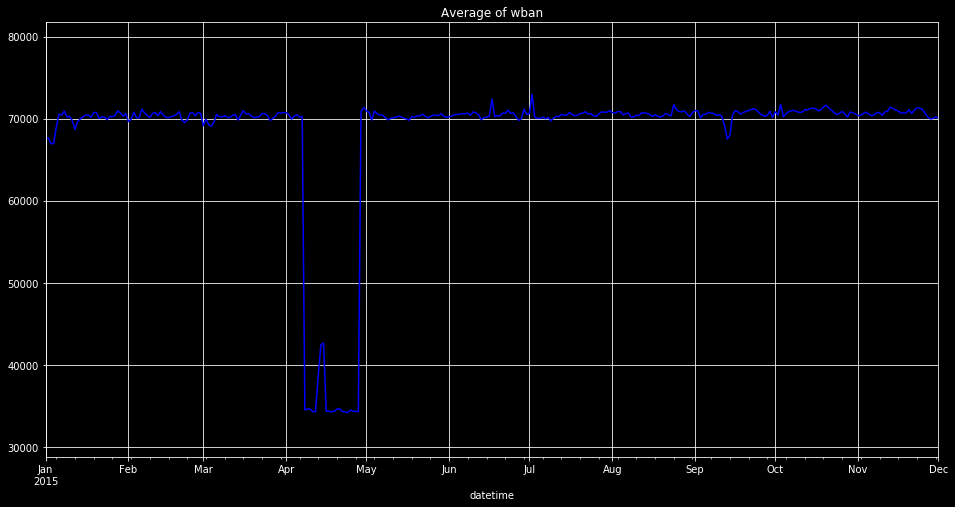

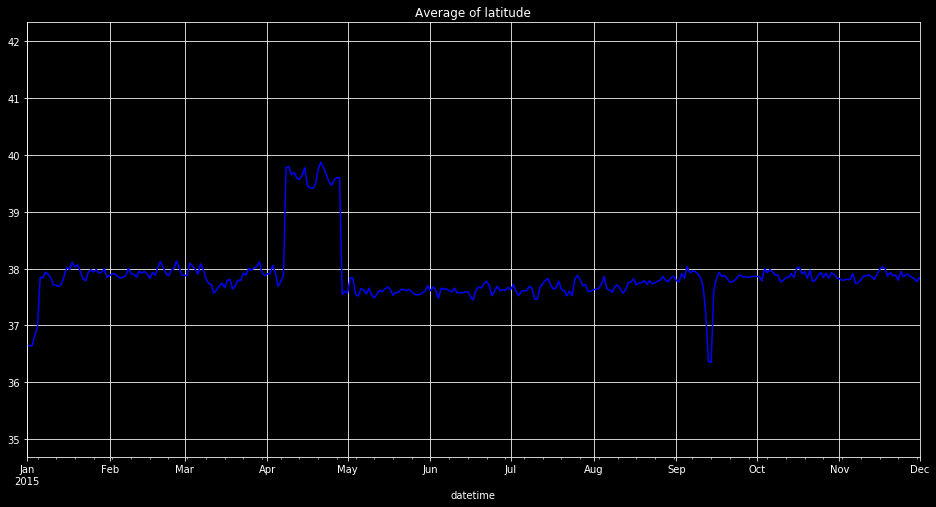

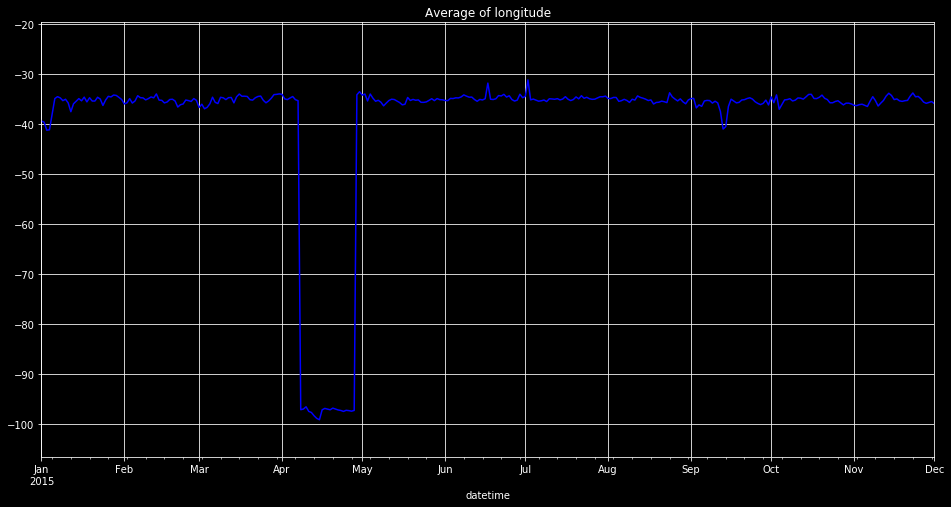

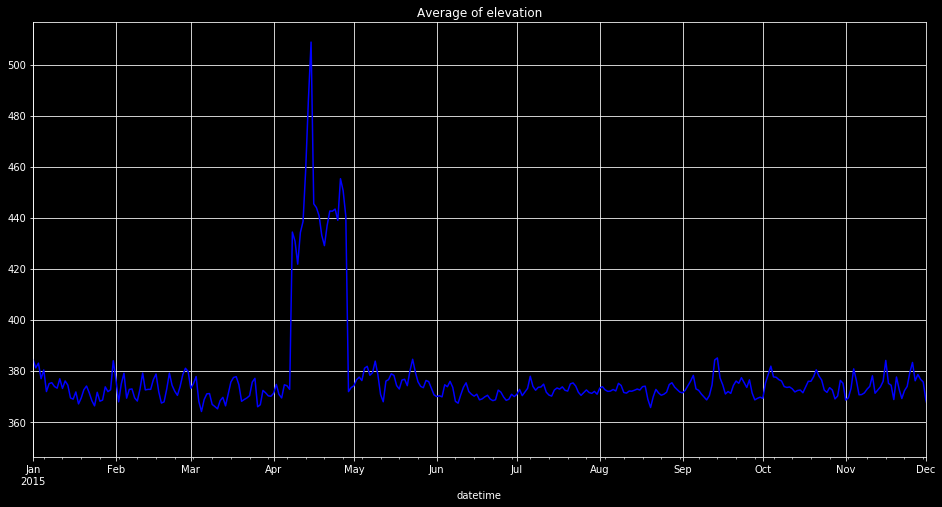

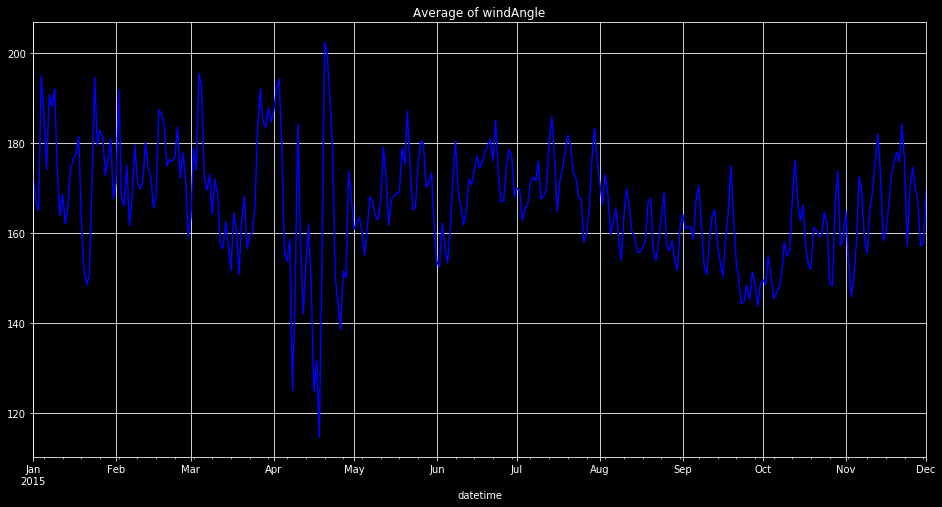

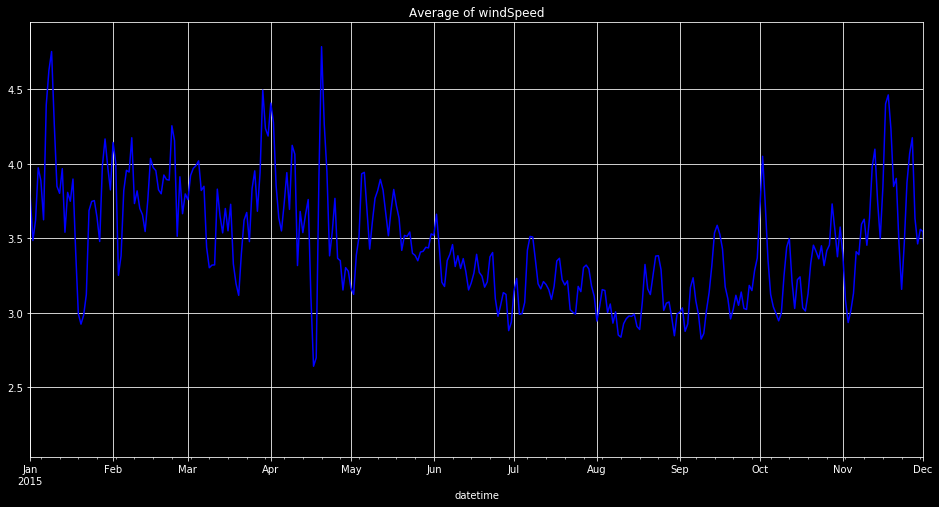

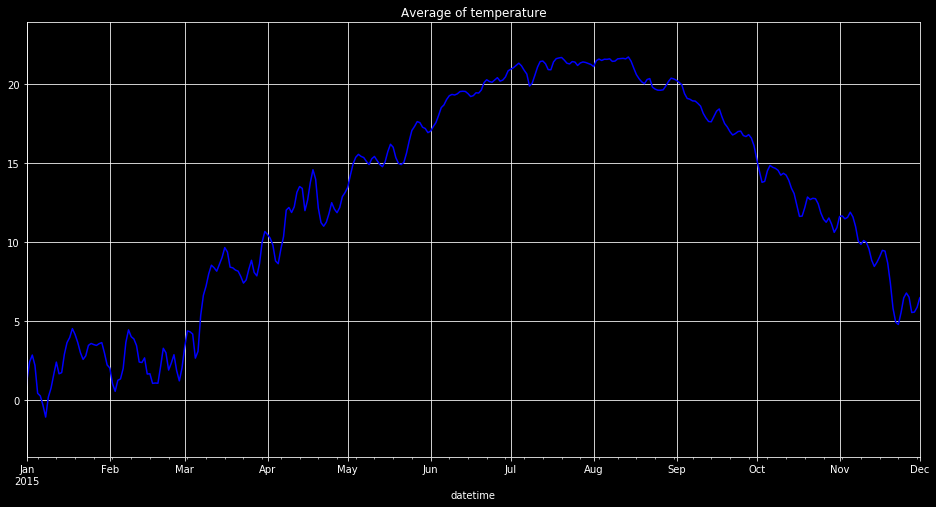

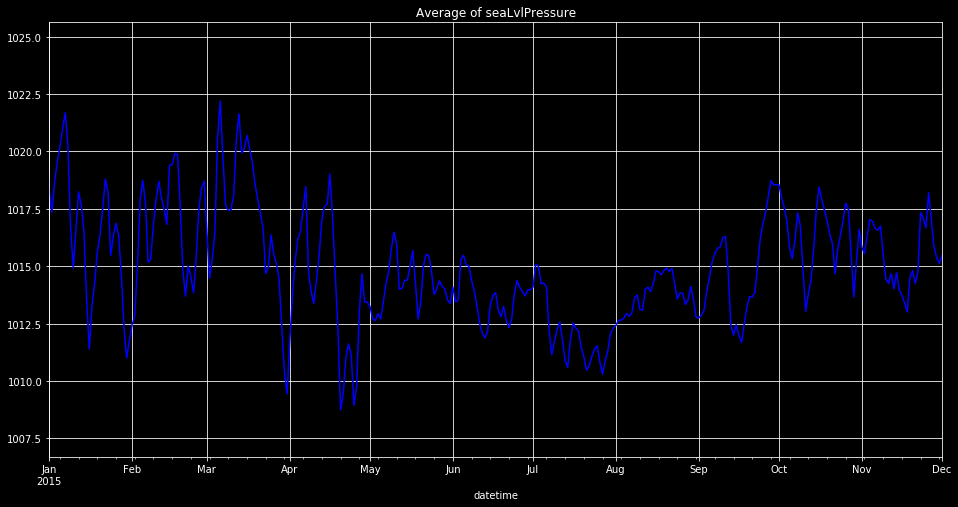

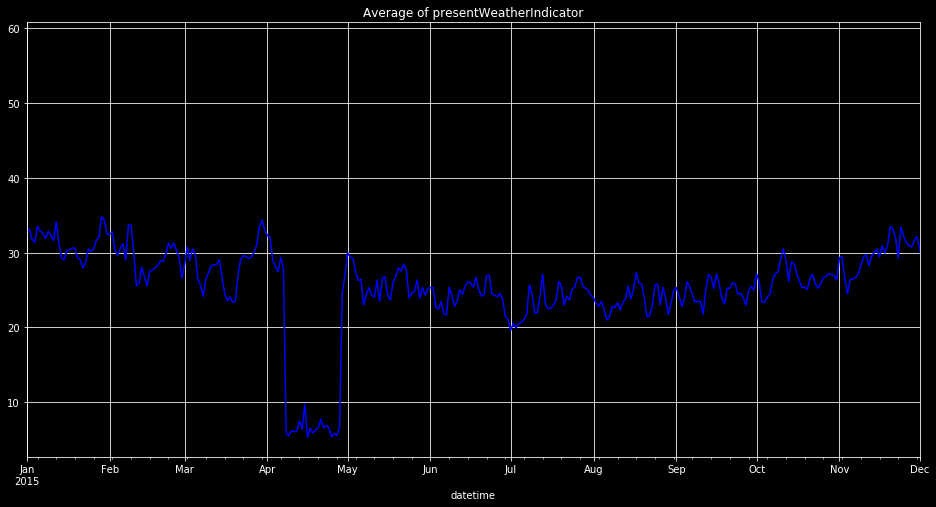

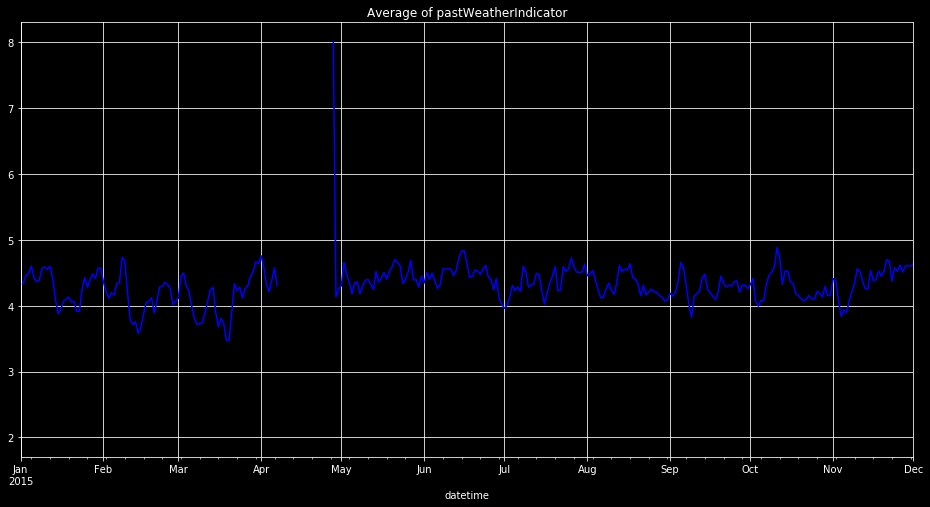

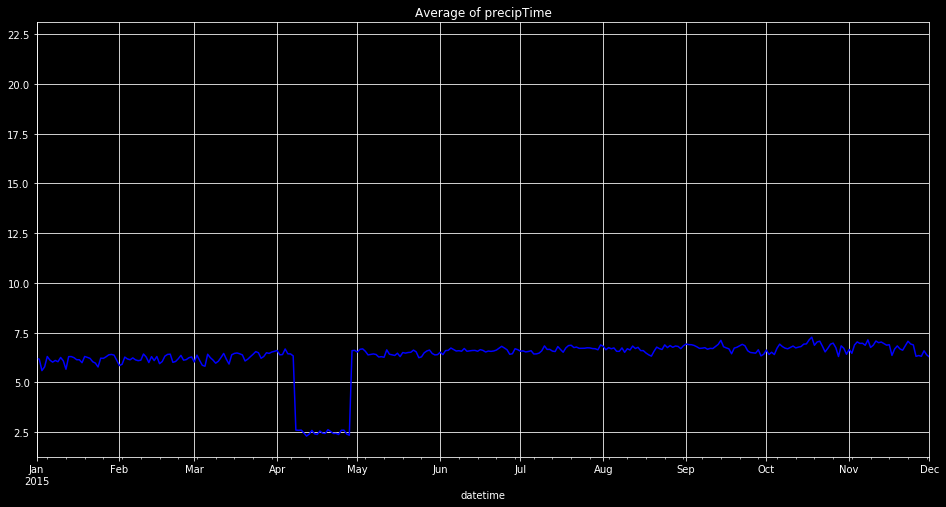

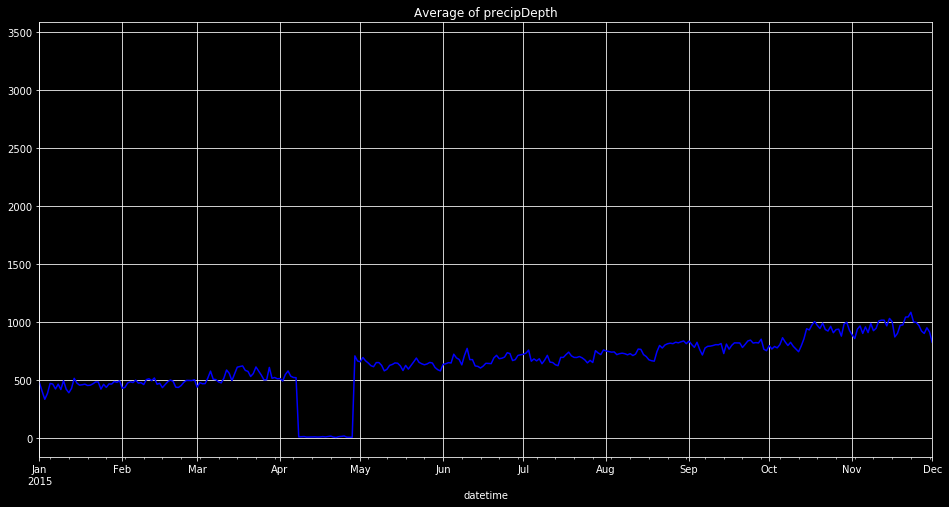

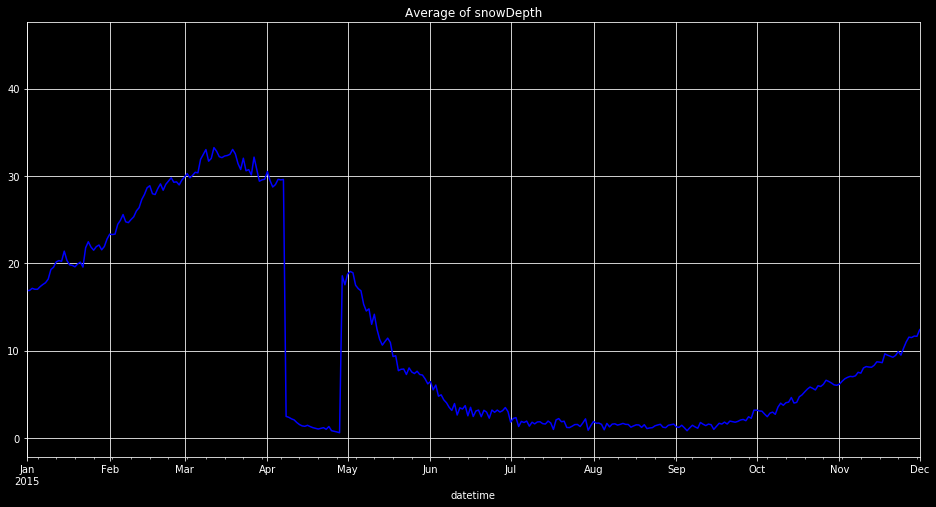

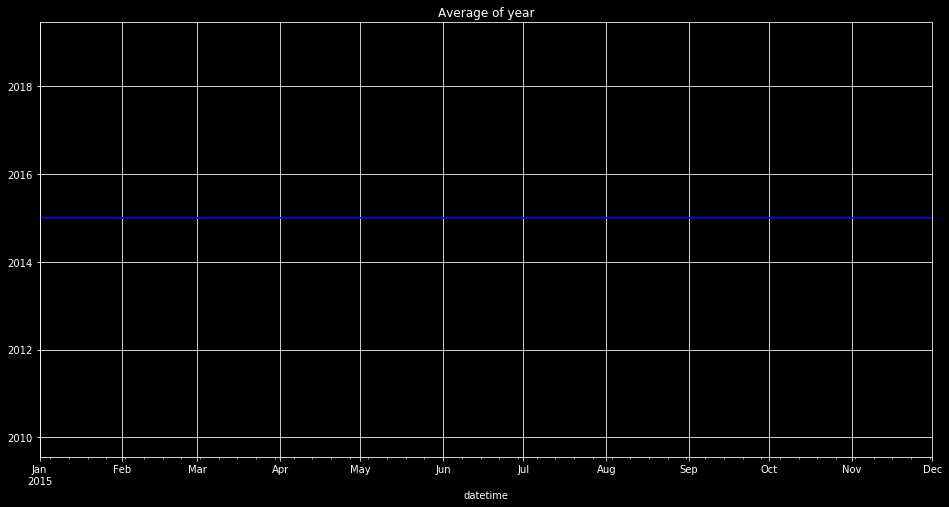

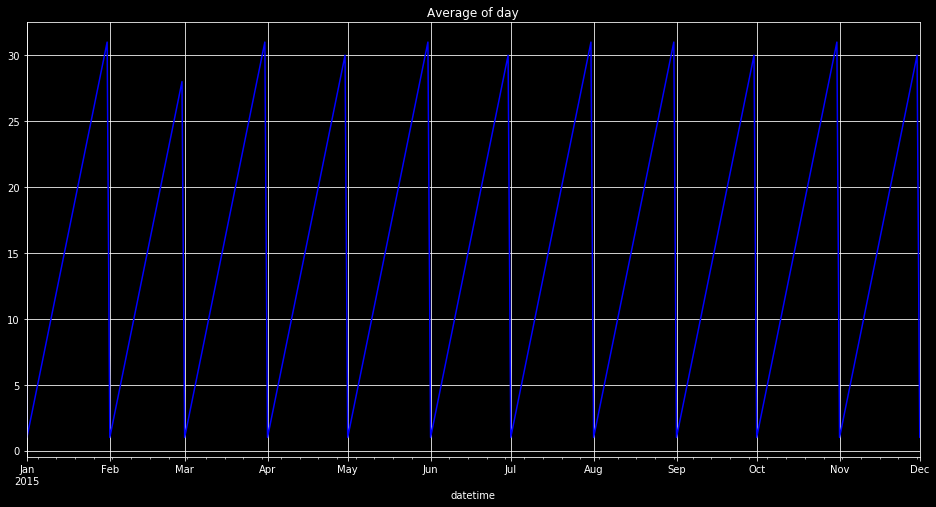

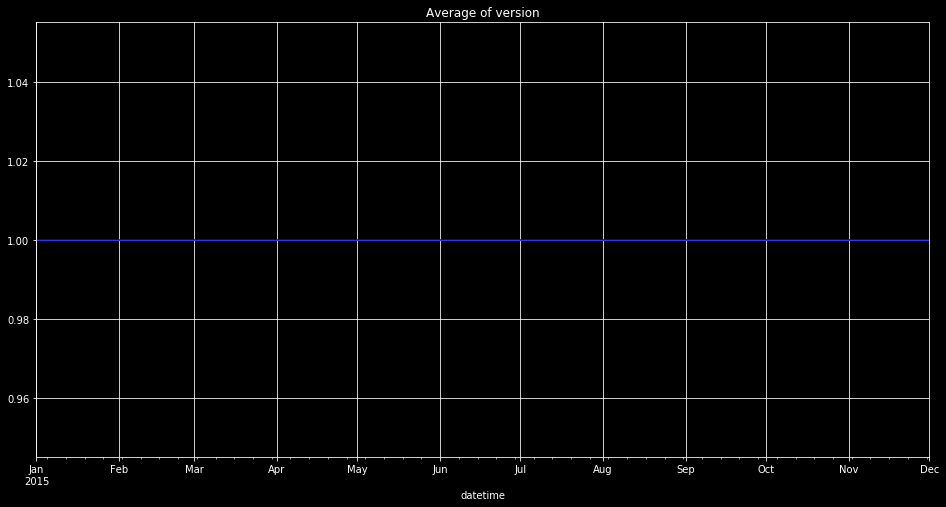

In [105]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2015, 1, 1), datetime(2015, 12, 1)])
    plt.grid()
    
    run.log_image(col, plot=plt)

In [95]:
df.memory_usage(index=True, deep=True).sum().compute()

542550664244

In [96]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 21 entries, usaf to version
dtypes: object(5), float64(13), int64(3)

See if the cluster works

In [ ]:
import time
import numpy as np
from dask import delayed, visualize

def inc(x):
    time.sleep(abs(np.random.normal(5, 2)))
    return x + 1

fut = []
for i in range(10):
    fut.append( c.submit(delayed(inc), i) )

fut

In [ ]:
for i in fut:
    print(i.result())

In [ ]:
def sum(a):
    x = 0
    for y in a:
        x += y
    return x

results = []
for f in fut:
    results.append(f.result())
    
fut2 = c.submit(sum, results)
fut2

In [ ]:
fut2.result().compute()

In [ ]:
visualize(fut2.result())

# Training on Large Datasets
(from https://github.com/dask/dask-tutorial)

Sometimes you'll want to train on a larger than memory dataset. `dask-ml` has implemented estimators that work well on dask arrays and dataframes that may be larger than your machine's RAM.

In [ ]:
from dask.distributed import Client
import joblib
import dask.array as da
import dask.delayed
from sklearn.datasets import make_blobs
import numpy as np

We'll make a small (random) dataset locally using scikit-learn.

In [ ]:
n_centers = 12
n_features = 20

X_small, y_small = make_blobs(n_samples=1000, centers=n_centers, n_features=n_features, random_state=0)

centers = np.zeros((n_centers, n_features))

for i in range(n_centers):
    centers[i] = X_small[y_small == i].mean(0)
    
centers[:4]

The small dataset will be the template for our large random dataset.
We'll use `dask.delayed` to adapt `sklearn.datasets.make_blobs`, so that the actual dataset is being generated on our workers. 

In [ ]:
n_samples_per_block = 200000
n_blocks = 500

delayeds = [dask.delayed(make_blobs)(n_samples=n_samples_per_block,
                                     centers=centers,
                                     n_features=n_features,
                                     random_state=i)[0]
            for i in range(n_blocks)]
arrays = [da.from_delayed(obj, shape=(n_samples_per_block, n_features), dtype='float64')
          for obj in delayeds]
X = da.concatenate(arrays)
X

In [ ]:
# Check the size of the array
X.nbytes / 1e9

In [ ]:
# Only run this on the cluster.
X = X.persist()  

The algorithms implemented in Dask-ML are scalable. They handle larger-than-memory datasets just fine.

They follow the scikit-learn API, so if you're familiar with scikit-learn, you'll feel at home with Dask-ML.

In [ ]:
from dask_ml.cluster import KMeans
clf = KMeans(init_max_iter=3, oversampling_factor=10)

In [ ]:
%time clf.fit(X)

In [ ]:
clf.labels_

In [ ]:
clf.labels_[:10].compute()

## Shut cluster down
To shut the cluster down, cancel the job that runs the cluster. 

In [137]:
for run in ws.experiments['dask'].get_runs():
    if run.get_status() == "Running":
        print(f'cancelling run {run.id}')
        run.cancel()

cancelling run dask_1576202839_c1820fde


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

### Just for convenience, get the latest running Run

In [ ]:
for run in ws.experiments['dask'].get_runs():
    if run.get_status() == "Running":
        print(f'latest running run is {run.id}')
        break